In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize, sent_tokenize
from textblob import TextBlob
from nltk.corpus import stopwords
from string import punctuation
import seaborn as sns
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from keras.models import Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from xgboost import XGBClassifier


In [37]:
#load the dataframe and rename the columns so that it's easier to understand

df = pd.read_csv('../input/spam.csv', encoding='latin-1')
df = df.iloc[:,:2]
df = pd.get_dummies(df, columns = ['v1'], drop_first = True)
df.rename(columns = {'v1_spam': 'Spam'}, inplace = True)
df.rename(columns = {'v2': 'Text'}, inplace = True)
df.head()

,Text,Spam
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


0    4825
1     747
Name: Spam, dtype: int64

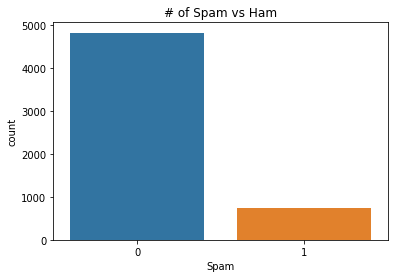

In [38]:
#check whats the balance between spam and ham 

sns.countplot(df['Spam'])
plt.title('# of Spam vs Ham')

df['Spam'].value_counts()

In [39]:
def AmountUpper(x):
    count = 0
    for letter in x:
        if letter.isupper():
            count = count + 1
            
    return count

df['Count_Upper'] = df['Text'].apply(AmountUpper)
df.head()

,Text,Spam,Count_Upper
0,"Go until jurong point, crazy.. Available only ...",0,3
1,Ok lar... Joking wif u oni...,0,2
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,10
3,U dun say so early hor... U c already then say...,0,2
4,"Nah I don't think he goes to usf, he lives aro...",0,2


Text(0.5, 1.0, 'Upper Letters Spam vs Ham')

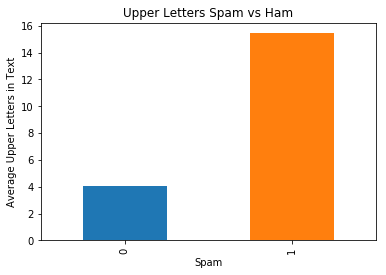

In [40]:
df.groupby(['Spam'])['Count_Upper'].mean().plot(kind = 'bar')
plt.ylabel('Average Upper Letters in Text')
plt.title('Upper Letters Spam vs Ham')

It is interesting to see that Spam text have more upper letters, will keep this as an additional feature

In [41]:
#preprocessing the data
#remove stopwords
removeWords = set(stopwords.words('english')+list(punctuation))


# Use TextBlob for stemming
def textblob_tokenizer(str_input):
    blob = TextBlob(str_input.lower())
    tokens = blob.words
    words = [token.stem() for token in tokens]
    return words

#tfidfvectorizer
vectorizer = TfidfVectorizer(lowercase=False, tokenizer = textblob_tokenizer, stop_words=removeWords)
X = vectorizer.fit_transform(df['Text'])
text_columns = vectorizer.get_feature_names()
#X_df = pd.SparseDataFrame(X,columns = text_columns, default_fill_value=0)

#X_df['Count_Upper'] = df['Count_Upper']

#Normalizer Scaler - Text
stdScaler = Normalizer()
X = stdScaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, df['Spam'], test_size=0.25, random_state=101)

/opt/conda/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [42]:
len(text_columns)

7867

In [43]:
#logistic Regression
model = LogisticRegression()
model.fit(X_train,y_train)
score = model.score(X_test,y_test)
print('Logistic Regression')
print(score)

Logistic Regression
0.9569274946159368


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic Regression accuracy is 95.7%, will try more models below. 
The metric we will be tracking is more focused on recall

In [44]:
#support vector machine with a grid search
def SVM_Model_Reports(X_train,y_train,X_test,y_test):
    model = SVC()

    parameters = [
        {'kernel':['linear', 'poly', 'rbf'],
         'C':[1,10,100]}
                 ]

    Grid = GridSearchCV(model, parameters, cv = 4)
    Grid.fit(X_train,y_train)
    means = Grid.cv_results_['mean_test_score']
    stds = Grid.cv_results_['std_test_score']
    params = Grid.cv_results_['params']
    print('SVM with Grid Search')
    for mean, std, params in zip(means, stds, params):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    
#create the confusion matrix
    
    y_pred = Grid.predict(X_test)
    _,recall,_,_ = precision_recall_fscore_support(y_test,y_pred)
    confusion_array= confusion_matrix(y_test,y_pred)
    confusion_df = pd.DataFrame(confusion_array, columns = ['Pred 0','Pred 1'], index = ['True 0', 'True 1'])
    sns.heatmap(confusion_df, annot = True, cmap="YlGnBu", fmt='g')
    plt.title(f'Recall {recall}')
    
    print('========================================================')
    
    print('Classification Report')
    print(classification_report(y_test, y_pred))

/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVM with Grid Search
0.977 (+/-0.009) for {'C': 1, 'kernel': 'linear'}
0.864 (+/-0.000) for {'C': 1, 'kernel': 'poly'}
0.864 (+/-0.000) for {'C': 1, 'kernel': 'rbf'}
0.979 (+/-0.011) for {'C': 10, 'kernel': 'linear'}
0.864 (+/-0.000) for {'C': 10, 'kernel': 'poly'}
0.864 (+/-0.000) for {'C': 10, 'kernel': 'rbf'}
0.979 (+/-0.011) for {'C': 100, 'kernel': 'linear'}
0.864 (+/-0.000) for {'C': 100, 'kernel': 'poly'}
0.864 (+/-0.000) for {'C': 100, 'kernel': 'rbf'}
Classification Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1214
           1       0.99      0.87      0.93       179

   micro avg       0.98      0.98      0.98      1393
   macro avg       0.99      0.93      0.96      1393
weighted avg       0.98      0.98      0.98      1393



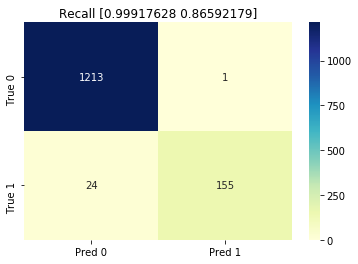

In [45]:
SVM_Model_Reports(X_train,y_train,X_test,y_test)
#recall of 87% can be improved

Since the data is skewed, spam to ham ratio is not even, will program a SMOTE to even out the ratio and return the model

/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVM with Grid Search
0.996 (+/-0.003) for {'C': 1, 'kernel': 'linear'}
0.769 (+/-0.096) for {'C': 1, 'kernel': 'poly'}
0.907 (+/-0.005) for {'C': 1, 'kernel': 'rbf'}
0.998 (+/-0.002) for {'C': 10, 'kernel': 'linear'}
0.769 (+/-0.096) for {'C': 10, 'kernel': 'poly'}
0.907 (+/-0.005) for {'C': 10, 'kernel': 'rbf'}
0.998 (+/-0.002) for {'C': 100, 'kernel': 'linear'}
0.769 (+/-0.096) for {'C': 100, 'kernel': 'poly'}
0.950 (+/-0.016) for {'C': 100, 'kernel': 'rbf'}
Classification Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1214
           1       0.99      0.87      0.93       179

   micro avg       0.98      0.98      0.98      1393
   macro avg       0.99      0.93      0.96      1393
weighted avg       0.98      0.98      0.98      1393



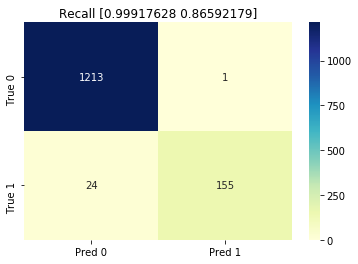

In [46]:
sm = SMOTE(random_state=101)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

SVM_Model_Reports(X_train_res,y_train_res,X_test,y_test)

Programming an Sequential model using Keras package using the SMOTE data

In [47]:
length = X_train.shape[1]

# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 5)

model = Sequential()
model.add(Dense(64,input_shape=(length,) , activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 64)                503552    
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 32)                4128      
_________________________________________________________________
dropout_9 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 33        
Total para

In [48]:
history = model.fit(X_train_res, y_train_res,batch_size=32,epochs=10, callbacks=[es], verbose=1,validation_split=0.2)

Train on 5777 samples, validate on 1445 samples
Epoch 1/10
5777/5777 [==============================] - 3s 527us/step - loss: 0.2107 - acc: 0.9081 - val_loss: 0.0061 - val_acc: 0.9993
Epoch 2/10
5777/5777 [==============================] - 2s 394us/step - loss: 0.0089 - acc: 0.9976 - val_loss: 4.9371e-04 - val_acc: 1.0000
Epoch 3/10
5777/5777 [==============================] - 2s 395us/step - loss: 9.1193e-04 - acc: 0.9998 - val_loss: 1.4691e-04 - val_acc: 1.0000
Epoch 4/10
5777/5777 [==============================] - 2s 375us/step - loss: 4.3871e-04 - acc: 1.0000 - val_loss: 4.5146e-05 - val_acc: 1.0000
Epoch 5/10
5777/5777 [==============================] - 2s 387us/step - loss: 1.9192e-04 - acc: 1.0000 - val_loss: 3.3093e-05 - val_acc: 1.0000
Epoch 6/10
5777/5777 [==============================] - 2s 390us/step - loss: 1.4115e-04 - acc: 1.0000 - val_loss: 1.3309e-05 - val_acc: 1.0000
Epoch 7/10
5777/5777 [==============================] - 2s 379us/step - loss: 1.0451e-04 - acc: 1.00

In [49]:
y_pred = model.predict_classes(X_test)

print('Classification Report from Kera Sequential Model')
print(classification_report(y_test, y_pred))

Classification Report from Kera Sequential Model
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1214
           1       0.97      0.85      0.91       179

   micro avg       0.98      0.98      0.98      1393
   macro avg       0.98      0.93      0.95      1393
weighted avg       0.98      0.98      0.98      1393



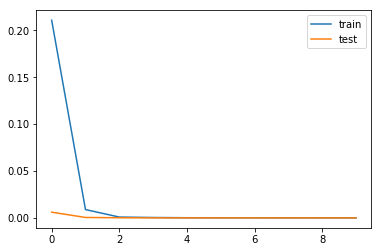

In [50]:
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Programmed an XGBoost Classifer to see if the recall is better

In [51]:
model = XGBClassifier()
model.fit(X_train_res,y_train_res)
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

print('Classification Report from XGBoost Model')
print(classification_report(y_test, predictions))

Classification Report from XGBoost Model
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1214
           1       0.81      0.79      0.80       179

   micro avg       0.95      0.95      0.95      1393
   macro avg       0.89      0.88      0.88      1393
weighted avg       0.95      0.95      0.95      1393



Conclusion: the strongest model is keras neural network

Key learning: TfidfVectorizer with stop words, and stemming